## Extension to Question 4
Just playing around, trying other trading strategies (combine MACD with RSI), trying to implement accounting for transaction fees and see what would be the net PnL and net Sharpe, implement weights to positions in the trading strategy in a robust manner (i.e. normalize weights), try to find a vectorized RSI trading strategy, check how long a position is held.

In [90]:
# Import Python packages
import math
import os
import random
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from itertools import islice
import seaborn as sns
from numba import njit

In [2]:
data_file = "../data/MarketData.csv"
try:
    # Read in data set from the csv file, skip initial metadata rows (first 3 rows)
    f = open(data_file, 'rb')
    df = pd.read_csv(f, skiprows = 3, header = [0, 1, 2, 3])

    # Drop the first column name from the multi-index (for "Dates" column)
    df.columns = ['Dates'] + [f"{col[0]} ({col[1]})" for col in df.columns[1:]]

    # Convert "Dates" column to datetime format, European date format
    df["Dates"] = pd.to_datetime(df["Dates"], dayfirst=True)
    
except:
    print('Error opening file/loading data')

# Display the first few rows
df

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
0,2010-01-01,7375.0,2230.0,2560.0,2432.0,16950,79.36
1,2010-01-04,7500.0,2267.0,2574.0,2515.0,17450,81.51
2,2010-01-05,7485.0,2302.0,2575.0,2522.5,17375,81.77
3,2010-01-06,7660.0,2377.0,2718.0,2680.0,17825,83.18
4,2010-01-07,7535.0,2310.0,2607.0,2599.0,17475,82.66
...,...,...,...,...,...,...,...
3386,2022-12-26,8349.5,2389.5,2965.0,2273.5,23934,79.56
3387,2022-12-27,8349.5,2389.5,2965.0,2273.5,23934,79.53
3388,2022-12-28,8443.0,2381.0,3005.5,2218.0,24734,78.96
3389,2022-12-29,8418.0,2405.0,2984.5,2272.5,24915,78.40


In [3]:
# Match column names to simple commodity names and colours
commodity_mapping = {
    'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
    'LME ALUMINUM  3MO ($) (LMAHDS03 Comdty)': ('Aluminum', 'blue'),
    'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green'),
    'LME LEAD      3MO ($) (LMPBDS03 Comdty)': ('Lead', 'red'),
    'LME TIN       3MO ($) (LMSNDS03 Comdty)': ('Tin', 'purple'),
    'Generic 1st \'CL\' Future (CL1 Comdty)': ('Crude Oil', 'brown')
}
commodity_mapping

{'LME COPPER    3MO ($) (LMCADS03 Comdty)': ('Copper', 'orange'),
 'LME ALUMINUM  3MO ($) (LMAHDS03 Comdty)': ('Aluminum', 'blue'),
 'LME ZINC      3MO ($) (LMZSDS03 Comdty)': ('Zinc', 'green'),
 'LME LEAD      3MO ($) (LMPBDS03 Comdty)': ('Lead', 'red'),
 'LME TIN       3MO ($) (LMSNDS03 Comdty)': ('Tin', 'purple'),
 "Generic 1st 'CL' Future (CL1 Comdty)": ('Crude Oil', 'brown')}

In [4]:
df_train = df[df['Dates'].dt.year.isin(range(2010, 2020))]
df_train

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
0,2010-01-01,7375.0,2230.0,2560.0,2432.0,16950,79.36
1,2010-01-04,7500.0,2267.0,2574.0,2515.0,17450,81.51
2,2010-01-05,7485.0,2302.0,2575.0,2522.5,17375,81.77
3,2010-01-06,7660.0,2377.0,2718.0,2680.0,17825,83.18
4,2010-01-07,7535.0,2310.0,2607.0,2599.0,17475,82.66
...,...,...,...,...,...,...,...
2603,2019-12-25,6215.0,1814.0,2274.0,1947.0,17125,61.11
2604,2019-12-26,6215.0,1814.0,2274.0,1947.0,17125,61.68
2605,2019-12-27,6214.0,1825.0,2305.0,1939.0,17120,61.72
2606,2019-12-30,6219.0,1827.0,2306.0,1942.0,17000,61.68


In [5]:
df_test = df[df['Dates'].dt.year.isin(range(2020, 2023))]
df_test

,Dates,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
2608,2020-01-01,6174.0,1810.0,2272.0,1927.0,17175,61.06
2609,2020-01-02,6188.0,1804.5,2310.0,1919.0,17190,61.18
2610,2020-01-03,6129.5,1824.0,2306.0,1919.0,16800,63.05
2611,2020-01-06,6138.5,1833.0,2324.5,1920.0,16850,63.27
2612,2020-01-07,6149.0,1816.0,2346.0,1906.0,17005,62.70
...,...,...,...,...,...,...,...
3386,2022-12-26,8349.5,2389.5,2965.0,2273.5,23934,79.56
3387,2022-12-27,8349.5,2389.5,2965.0,2273.5,23934,79.53
3388,2022-12-28,8443.0,2381.0,3005.5,2218.0,24734,78.96
3389,2022-12-29,8418.0,2405.0,2984.5,2272.5,24915,78.40


In [6]:
df.set_index('Dates', inplace=True)

Define functions to calculate returns, PnL, annualized vol, Sharpe and Sortino ratios, drawdown etc., as well as plotting scripts.

In [7]:
# Calculate daily returns
df_returns = df.pct_change()

df_returns_train = df_returns[df_returns.index.year.isin(range(2010, 2020))]
df_returns_test = df_returns[df_returns.index.year.isin(range(2020, 2023))]

In [165]:
# Calculate the annualized volatility on the price of all commodities
def calc_annualized_vol(df_returns, trading_days = 252):

    df_vol = df_returns.rolling(window=trading_days, min_periods=20).std() * np.sqrt(252)

    return df_vol

In [9]:
df_vol = calc_annualized_vol(df_returns)

df_vol_train = df_vol[df_vol.index.year.isin(range(2010, 2020))]
df_vol_test = df_vol[df_vol.index.year.isin(range(2020, 2023))]

In [10]:
def calculate_weight_matrix(df_positions, df_vol):

    df_weight_matrix = df_positions/df_vol

    return df_weight_matrix

In [11]:
def calculate_strategy_returns(df_returns, df_weight_matrix):

    # Shift weight matrix one row down so we can match the position with the corresponding return on the position
    df_weight_matrix = df_weight_matrix.shift(1)

    # Calculate the daily returns for each position
    df_strategy_returns = df_weight_matrix * df_returns

    return df_strategy_returns

In [169]:
def calculate_cumulative_returns(df_strategy_returns):

    # Sum all asset returns per row to create a single return column
    df_summed_returns = df_strategy_returns.sum(axis=1).to_frame(name="Strategy Returns")

    # Compute cumulative returns
    df_cumulative_returns = df_summed_returns.cumsum()
    df_cumulative_returns = df_cumulative_returns.rename(columns={"Strategy Returns": "Cumulative Returns"})

    return df_cumulative_returns, df_summed_returns

In [13]:
def calculate_drawdown(df_cumulative_returns):

    # Track running maximum (peak)
    df_cummulative_max = df_cumulative_returns.cummax()
    
    # Calculate drawdown
    df_drawdown = (df_cumulative_returns - df_cummulative_max) / df_cummulative_max 
    df_drawdown = df_drawdown.rename(columns={"Cumulative Returns": "Drawdown"})
    
    return df_drawdown

In [14]:
def plot_cumulative_returns(df_cumulative_returns, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_cumulative_returns.index, df_cumulative_returns["Cumulative Returns"], label="Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Returns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('cumulative_returns_'+strategy+'.pdf')
    plt.show()

In [15]:
def plot_strategy_returns(df_strategy_returns, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_strategy_returns.index, df_strategy_returns["Strategy Returns"], label="Strategy Returns")
    plt.xlabel("Date")
    plt.ylabel("Strategy Return")
    plt.title("Strategy Returns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('strategy_returns_'+strategy+'.pdf')
    plt.show()

In [16]:
def plot_drawdown(df_drawdown, strategy = ''):

    plt.figure(figsize=(10, 5))
    plt.plot(df_drawdown.index, df_drawdown["Drawdown"], label="Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.title("Drawdowns Over Time - "+strategy+" strategy")
    plt.legend()
    plt.grid(True)
    plt.savefig('drawdown_'+strategy+'.pdf')
    plt.show()

In [189]:
def calculate_sortino_ratio(df_summed_returns):

    # Calculate the annualized Sortino ratio assuming 0 risk-free rate, first selecting the downside returns
    downside_returns = df_summed_returns[df_summed_returns < 0] 
    downside_std = downside_returns.std()

    if downside_std == 0:
        sortino_ratio = np.inf
    else:
        sortino_ratio = (downside_returns.mean() / downside_std) * np.sqrt(252)

    return sortino_ratio

In [190]:
def calculate_sharpe_ratio(df_summed_returns):

    # Calculate the annualized Sharpe ratio assuming 0 risk-free rate
    sharpe_ratio = (df_summed_returns.mean() / df_summed_returns.std()) * np.sqrt(252)

    return sharpe_ratio

Define functions to calculate MACD and RSI

In [19]:
def macd(df, fast_window=12, slow_window=26, signal_window=9):

    df_fast_ema = df.ewm(span=fast_window, adjust=False).mean()  # Fast EMA (e.g. 12)
    df_slow_ema = df.ewm(span=slow_window, adjust=False).mean()  # Slow EMA (e.g. 26)
    df_macd_line = df_fast_ema - df_slow_ema  # MACD line (Fast - Slow)
    df_signal_line = df_macd_line.ewm(span=signal_window, adjust=False).mean()  # Signal Line (e.g. 9)
    df_macd_histogram = df_macd_line - df_signal_line # MACD Histogram

    return df_macd_line, df_signal_line, df_macd_histogram

In [20]:
def rsi(df, period=14):

    # Step 1 of RSI calculation: use simple moving average (SMA) for the first period
    # Calculate daily price changes
    df_price_change = df.diff()

    # Separate gains and losses
    df_gains = df_price_change.where(df_price_change > 0, 0)
    df_losses = -df_price_change.where(df_price_change < 0, 0)

    # Compute initial average gain/loss (first 14 values using SMA)
    df_avg_gain = df_gains.rolling(window=period, min_periods=period).mean()
    df_avg_loss = df_losses.rolling(window=period, min_periods=period).mean()

    # # Step 2: Calculate the smoothed averages for RSI
    for i in range(period, len(df)):
        df_avg_gain.iloc[i] = ((df_avg_gain.iloc[i - 1] * (period - 1)) + df_gains.iloc[i]) / period
        df_avg_loss.iloc[i] = ((df_avg_loss.iloc[i - 1] * (period - 1)) + df_losses.iloc[i]) / period

    # Calculate RS (Relative Strength)
    df_rs = df_avg_gain / df_avg_loss

    # Calculate RSI using the formula
    df_rsi = 100 - (100 / (1 + df_rs))

    return df_rsi

In [21]:
# This function actually doesn't work the same way as the iterative, smoothed RSI calculation
# While pandas.ewm(alpha=1/period, adjust=False) approximates Wilder’s smoothing, it is not mathematically identical to the true iterative RSI formula you're using — especially in early values where the initial SMA bootstraps the smoothed average gain/loss.
def rsi_vectorized(df, period=14):
    """
    Fully vectorized RSI calculation using Wilder's method and pandas ewm.

    Parameters:
        df: DataFrame of prices (columns = assets, index = dates)
        period: Smoothing period (default = 14)

    Returns:
        DataFrame of RSI values
    """
    # Price change
    delta = df.diff()

    # Separate gains and losses
    gains = delta.clip(lower=0)
    losses = -delta.clip(upper=0)

    # Wilder-style exponential moving averages
    avg_gain = gains.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = losses.ewm(alpha=1/period, adjust=False).mean()

    # Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [91]:
@njit
def compute_rsi_numba(prices: np.ndarray, period: int) -> np.ndarray:
    n_rows, n_assets = prices.shape
    rsi = np.full((n_rows, n_assets), np.nan)

    for col in range(n_assets):
        price = prices[:, col]
        gains = np.zeros(n_rows)
        losses = np.zeros(n_rows)

        # Compute daily change
        for i in range(1, n_rows):
            change = price[i] - price[i - 1]
            gains[i] = max(change, 0)
            losses[i] = max(-change, 0)

        # Initial average gain/loss using SMA
        avg_gain = np.sum(gains[1:period+1]) / period
        avg_loss = np.sum(losses[1:period+1]) / period

        # Compute RSI from period onward
        for i in range(period + 1, n_rows):
            avg_gain = ((avg_gain * (period - 1)) + gains[i]) / period
            avg_loss = ((avg_loss * (period - 1)) + losses[i]) / period

            if avg_loss == 0:
                rs = np.inf
                rsi_val = 100
            else:
                rs = avg_gain / avg_loss
                rsi_val = 100 - (100 / (1 + rs))

            rsi[i, col] = rsi_val

    return rsi


In [96]:
rsi_period = 14
np_df = df.to_numpy()
np_rsi = compute_rsi_numba(np_df, rsi_period)
np_rsi

array([[        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan],
       ...,
       [58.05775765, 46.32829145, 46.66576901, 55.79828333, 64.32610342,
        51.97007541],
       [56.52499067, 50.30868898, 44.97676472, 62.85381356, 65.68803967,
        50.33646365],
       [53.71494414, 46.16111165, 43.99682292, 65.10979774, 64.12937348,
        55.35604782]])

Define RSI trading strategy that's fully vectorized in python. First we look when the RSI line is below 30 (buy signal) or above 70 (sell signal)

In [191]:
def rsi_positions(df_rsi):

    df_rsi_positions = pd.DataFrame(0, index=df_rsi.index, columns=df_rsi.columns)

    # Step 1: Define buy and sell signals
    # Vectorized condition for buys (RSI < 30 and not NaN)
    buy_signals = (df_rsi < 30) & df_rsi.notna()

    # Vectorized condition for sells (RSI > 70 and not NaN)
    sell_signals = (df_rsi > 70) & df_rsi.notna()

    # Step 2: Create signal +1 for buy, -1 for sell, 0 otherwise
    trade_signals = buy_signals.astype(int) - sell_signals.astype(int)

    # Step 3: Replace 0s with NaN for forward-filling only actual trade signals
    trade_signals = trade_signals.replace(0, np.nan)

    # Step 4: Forward fill the trade signals (to propagate latest position)
    df_rsi_positions = trade_signals.ffill().fillna(0).astype(int)

    # Step 5: Make sure we're only holding long positions (-1 or 1)
    df_rsi_positions = df_rsi_positions.clip(lower=-1, upper=1)
    
    return df_rsi_positions

In [212]:
def backtest_rsi(df_returns, df_rsi, df_vol):

    df_rsi_positions = rsi_positions(df_rsi)
    df_weight_matrix = calculate_weight_matrix(df_rsi_positions, df_vol)
    #df_weight_matrix = df_rsi_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [144]:
rsi_period = 21
#df_rsi = rsi_vectorized(df, rsi_period)
df_rsi = rsi(df, rsi_period)

# Split RSI dataframe by train and test
df_rsi_train = df_rsi[df_rsi.index.year.isin(range(2010, 2020))]
df_rsi_test = df_rsi[df_rsi.index.year.isin(range(2020, 2023))]

In [42]:
df_rsi_train[10:30]

,LME COPPER 3MO ($) (LMCADS03 Comdty),LME ALUMINUM 3MO ($) (LMAHDS03 Comdty),LME ZINC 3MO ($) (LMZSDS03 Comdty),LME LEAD 3MO ($) (LMPBDS03 Comdty),LME TIN 3MO ($) (LMSNDS03 Comdty),Generic 1st 'CL' Future (CL1 Comdty)
Dates,,,,,,
2010-01-15,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-19,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-20,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-21,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-22,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-25,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-26,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-27,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_rsi(df_returns_train, df_rsi_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_rsi(df_returns_test, df_rsi_test, df_vol_test)

In [215]:
sharpe_ratio_train

0.11135090863495332

In [216]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

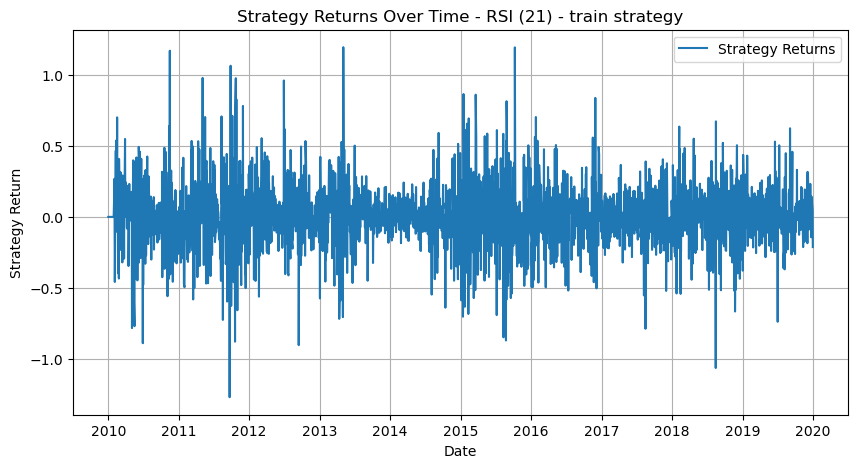

In [217]:
plot_strategy_returns(df_summed_returns_train, 'RSI (21) - train')

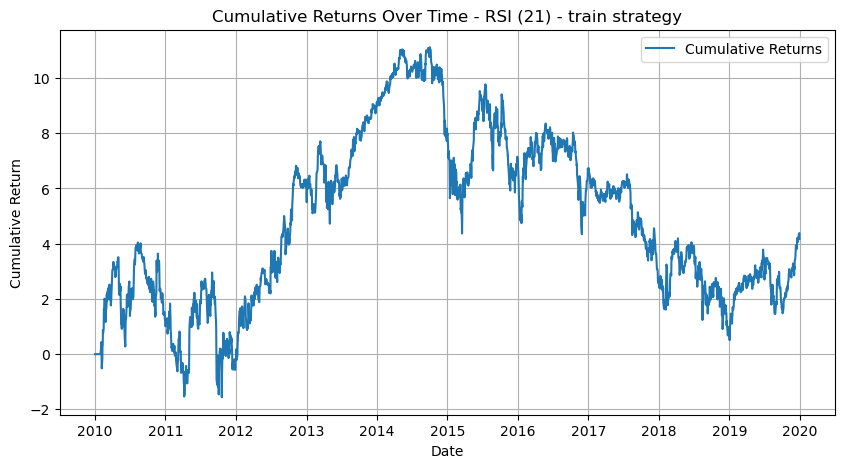

In [218]:
plot_cumulative_returns(df_cumulative_returns_train, 'RSI (21) - train')

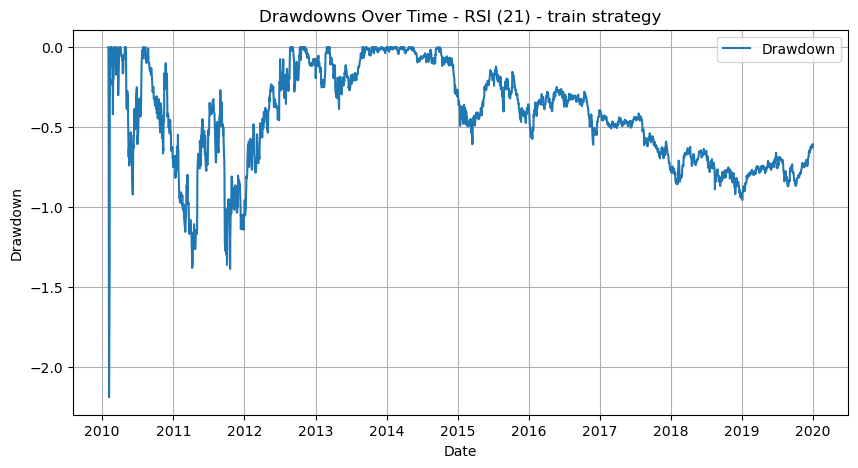

In [219]:
plot_drawdown(df_drawdown_train, 'RSI (21) - train')

In [220]:
sharpe_ratio_test

-1.1017306385235517

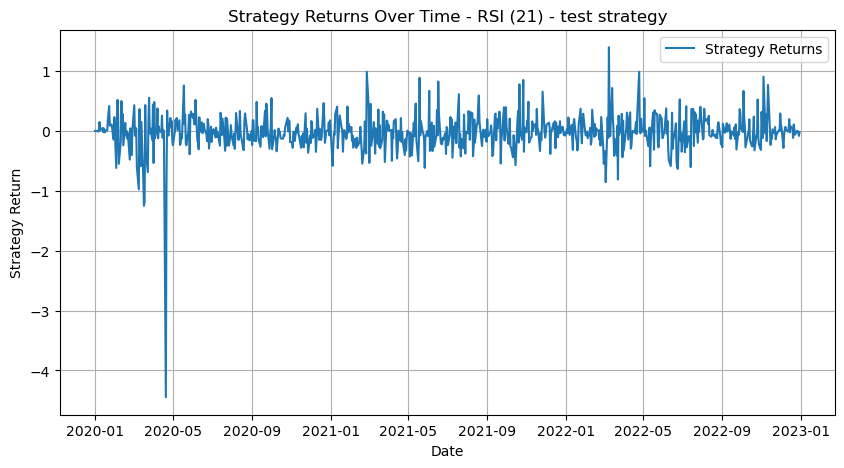

In [221]:
plot_strategy_returns(df_summed_returns_test, 'RSI (21) - test')

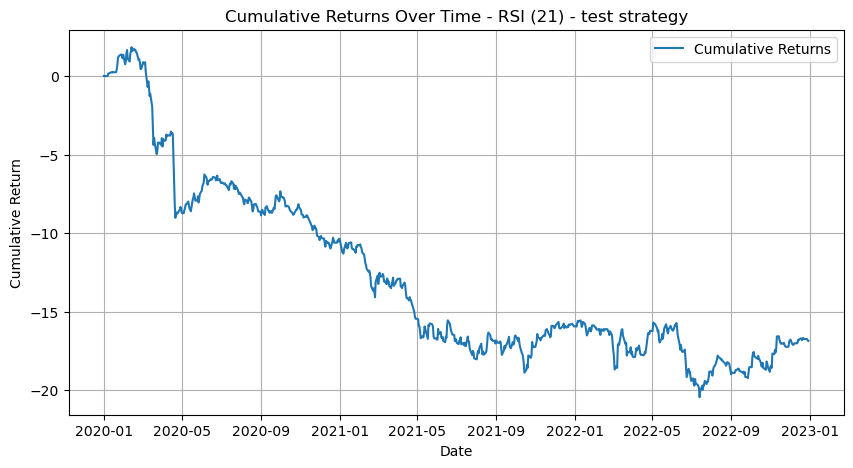

In [222]:
plot_cumulative_returns(df_cumulative_returns_test, 'RSI (21) - test')

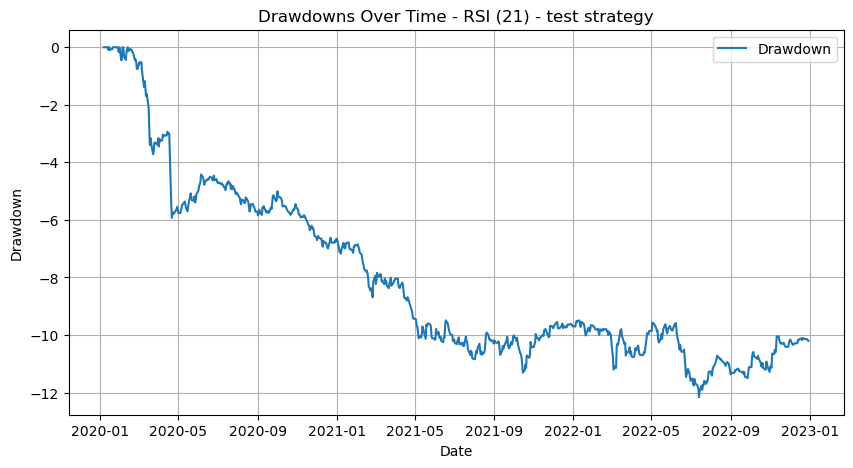

In [223]:
plot_drawdown(df_drawdown_test, 'RSI (21) - test')

Define MACD 0-cross line strategy

In [204]:
def macd_positions(df_signal_line):

    df_macd_positions = pd.DataFrame(np.nan, index=df_signal_line.index, columns=df_signal_line.columns)

    # Vectorized condition for buys (signal line > 0 and not NaN)
    buy_signals = (df_signal_line > 0) & df_signal_line.notna() 

    # Vectorized condition for sells (signal line < 0 and not NaN)
    sell_signals = (df_signal_line < 0) & df_signal_line.notna()

    # Apply trading logic
    df_macd_positions[buy_signals] = 1  # Buy
    df_macd_positions[sell_signals] = -1  # Sell

    return df_macd_positions

In [205]:
def backtest_macd_0cross(df_returns, df_signal_line, df_vol):

    df_macd_positions = macd_positions(df_signal_line)
    df_weight_matrix = calculate_weight_matrix(df_macd_positions, df_vol)
    #df_weight_matrix = df_macd_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [206]:
signal_window = 9
fast_window = 8
slow_window = 15

df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

# Split MACD dataframes by train and test
# df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
# df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

# df_macd_histogram_train = df_macd_histogram[df_macd_hitogram.index.year.isin(range(2010, 2020))]
# df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_macd_0cross(df_returns_train, df_signal_line_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_macd_0cross(df_returns_test, df_signal_line_test, df_vol_test)

In [207]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

In [208]:
sharpe_ratio_train

-0.08694069635707963

/tmp/ipykernel_614199/3166970215.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


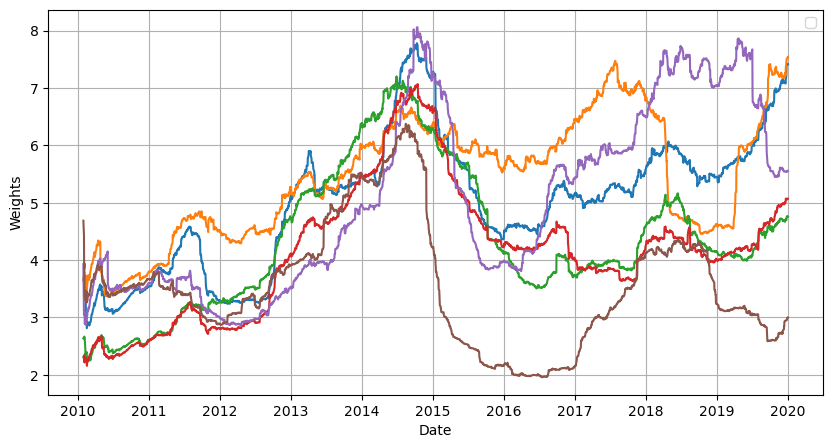

In [211]:
plt.figure(figsize=(10, 5))
#plt.plot(df_weight_matrix_train.index, df_weight_matrix_train.abs().sum(1))
plt.plot(df_weight_matrix_train.index, df_weight_matrix_train.abs())
plt.xlabel("Date")
plt.ylabel("Weights")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Dates'>

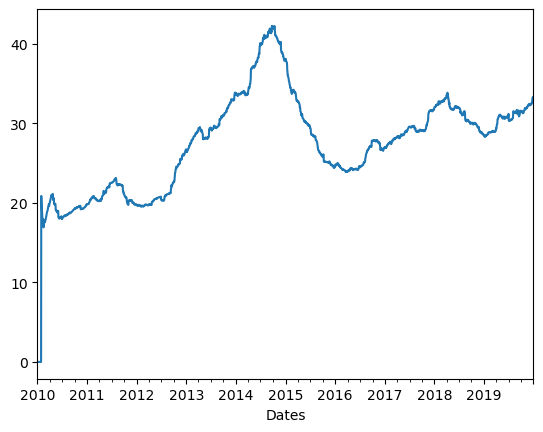

In [181]:
df_weight_matrix_train.abs().sum(1).plot()


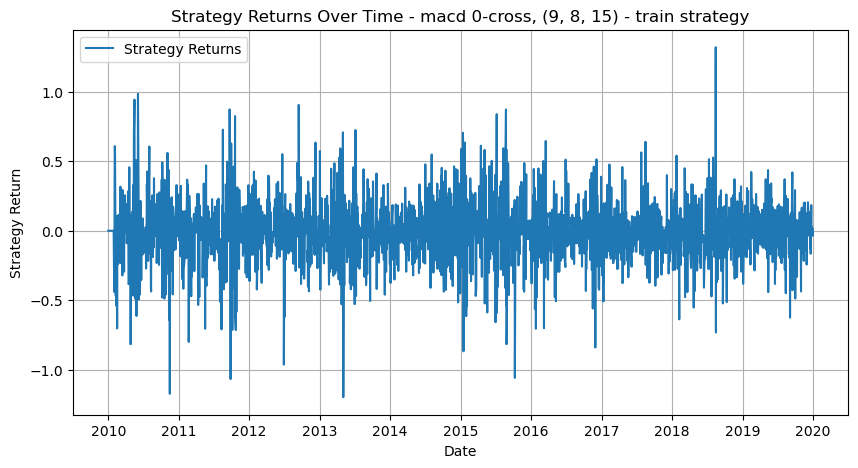

In [182]:
plot_strategy_returns(df_summed_returns_train, 'macd 0-cross, (9, 8, 15) - train')

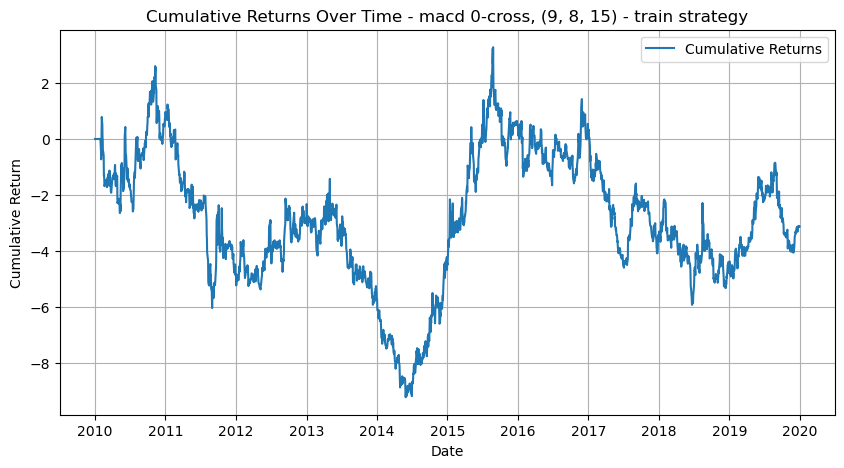

In [183]:
plot_cumulative_returns(df_cumulative_returns_train, 'macd 0-cross, (9, 8, 15) - train')

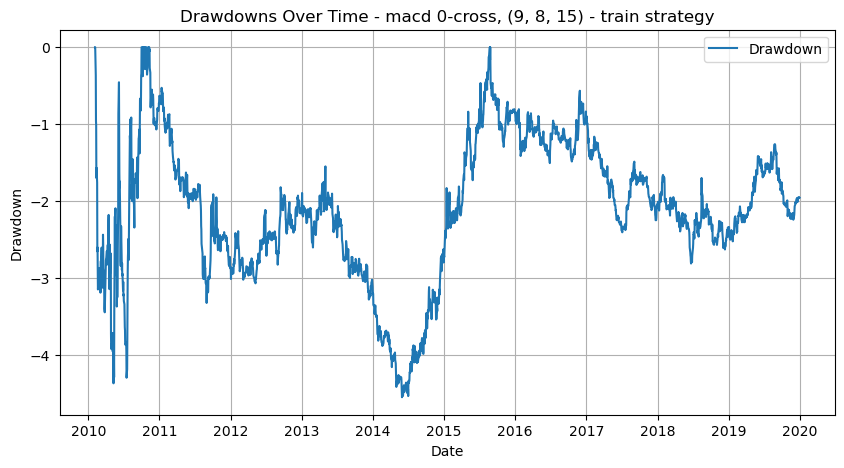

In [184]:
plot_drawdown(df_drawdown_train, 'macd 0-cross, (9, 8, 15) - train')

In [185]:
sharpe_ratio_test

1.41994219440368

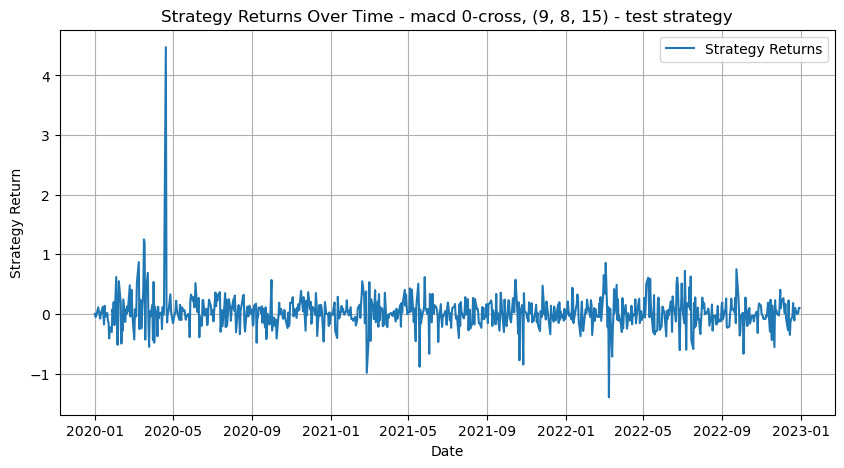

In [186]:
plot_strategy_returns(df_summed_returns_test, 'macd 0-cross, (9, 8, 15) - test')

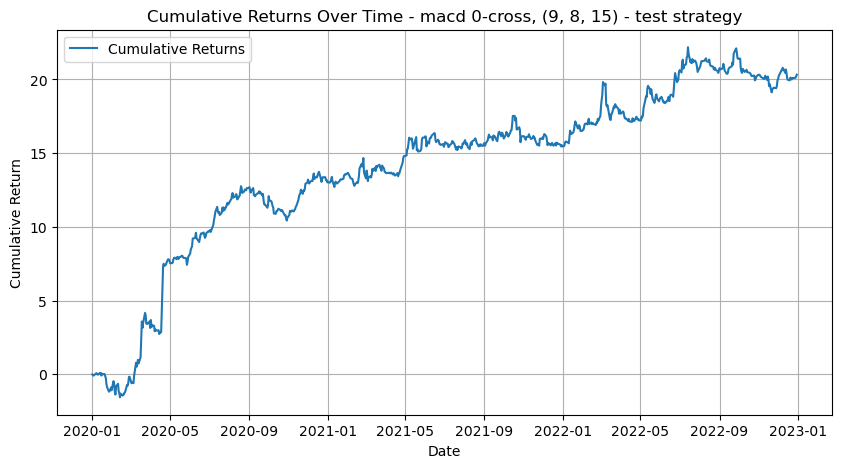

In [187]:
plot_cumulative_returns(df_cumulative_returns_test, 'macd 0-cross, (9, 8, 15) - test')

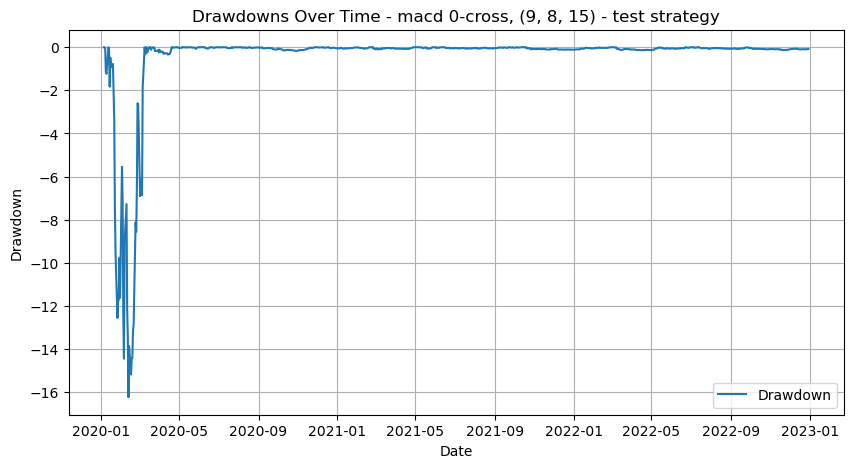

In [188]:
plot_drawdown(df_drawdown_test, 'macd 0-cross, (9, 8, 15) - test')

## Combine MACD and RSI strategies

Combination strategy between RSI and MACD line crossing strategy:

Buy when:

- RSI < 30 (oversold, ready to bounce)

- MACD crosses above signal line (bullish momentum)

Sell when:

- RSI > 70 (overbought)

- MACD crosses below signal line (bearish momentum)

In [224]:
def combined_rsi_macd_strategy(df_rsi, df_macd, df_signal_line):
    """
    Combine RSI and MACD indicators to produce trading positions.
    Buy when RSI < 30 and MACD > Signal Line (bullish confirmation)
    Sell when RSI > 70 and MACD < Signal Line (bearish confirmation)
    Hold otherwise.

    Returns:
        df_positions: -1 = short, 1 = long
    """
    # Buy signal: both RSI < 30 and MACD > Signal
    buy = (df_rsi < 30) & (df_macd > df_signal_line) & df_rsi.notna()

    # Sell signal: both RSI > 70 and MACD < Signal
    sell = (df_rsi > 70) & (df_macd < df_signal_line) & df_rsi.notna()

    # # Vectorized condition for buys (signal line > 0 and not NaN)
    # buy = (df_rsi < 30) & (df_signal_line > 0) & df_signal_line.notna() 

    # # Vectorized condition for sells (signal line < 0 and not NaN)
    # sell = (df_rsi > 70) & (df_signal_line < 0) & df_signal_line.notna()

    # Convert to trade signal: +1 for buy, -1 for sell, 0 otherwise
    signals = buy.astype(int) - sell.astype(int)

    # Replace 0s with NaN to enable forward-filling
    signals = signals.replace(0, np.nan)

    # Forward fill to propagate current position
    df_positions = signals.ffill().fillna(0).astype(int)

    # Ensure only -1 or 1 (short or long)
    df_positions = df_positions.clip(-1, 1)

    return df_positions


In [225]:
def backtest_rsi_macd_strategy(df_returns, df_rsi, df_macd, df_signal_line, df_vol):

    df_positions = combined_rsi_macd_strategy(df_rsi, df_macd, df_signal_line)
    #df_weight_matrix = calculate_weight_matrix(df_positions, df_vol)
    df_weight_matrix = df_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [226]:
rsi_period = 14
df_rsi = rsi(df, rsi_period)

# Split RSI dataframe by train and test
df_rsi_train = df_rsi[df_rsi.index.year.isin(range(2010, 2020))]
df_rsi_test = df_rsi[df_rsi.index.year.isin(range(2020, 2023))]

In [227]:
signal_window = 9
fast_window = 8
slow_window = 15

df_macd_line, df_signal_line, df_macd_histogram = macd(df, fast_window, slow_window, signal_window)

# Split MACD dataframes by train and test
df_macd_line_train = df_macd_line[df_macd_line.index.year.isin(range(2010, 2020))]
df_macd_line_test = df_macd_line[df_macd_line.index.year.isin(range(2020, 2023))]

df_signal_line_train = df_signal_line[df_signal_line.index.year.isin(range(2010, 2020))]
df_signal_line_test = df_signal_line[df_signal_line.index.year.isin(range(2020, 2023))]

# df_macd_histogram_train = df_macd_histogram[df_macd_hitogram.index.year.isin(range(2010, 2020))]
# df_macd_histogram_test = df_macd_histogram[df_macd_histogram.index.year.isin(range(2020, 2023))]

In [228]:
df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_rsi_macd_strategy(df_returns_train, df_rsi_train, df_macd_line_train, df_signal_line_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_rsi_macd_strategy(df_returns_test, df_rsi_test, df_macd_line_test, df_signal_line_test, df_vol_test)

In [229]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

In [230]:
sharpe_ratio_train

0.19255812789998203

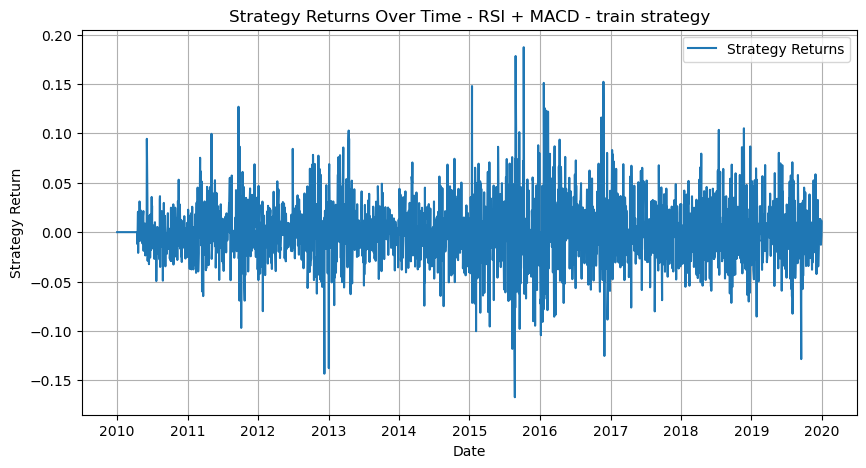

In [231]:
plot_strategy_returns(df_summed_returns_train, 'RSI + MACD - train')

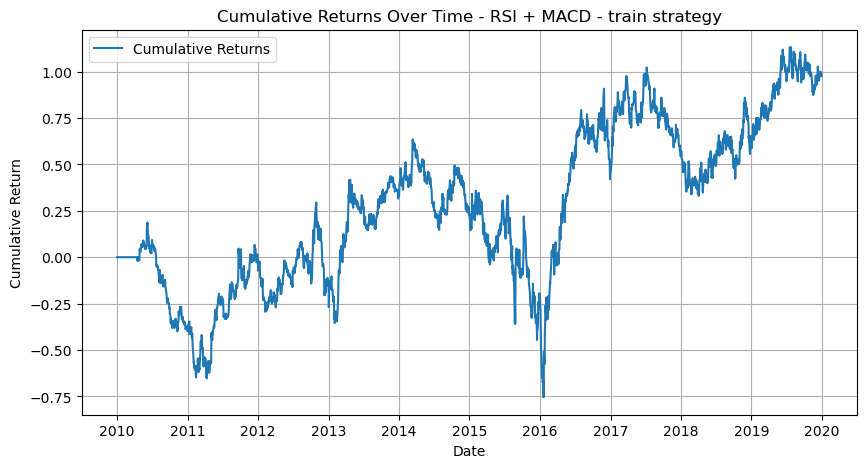

In [232]:
plot_cumulative_returns(df_cumulative_returns_train, 'RSI + MACD - train')

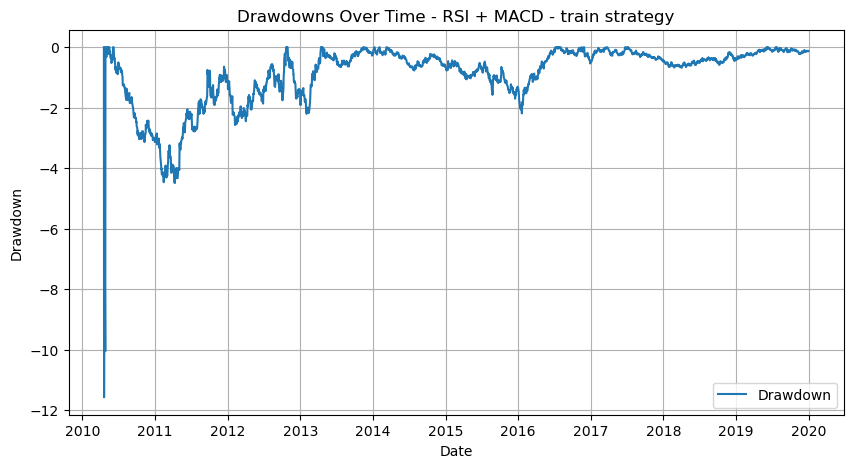

In [233]:
plot_drawdown(df_drawdown_train, 'RSI + MACD - train')

In [234]:
sharpe_ratio_test

-0.7394200075097122

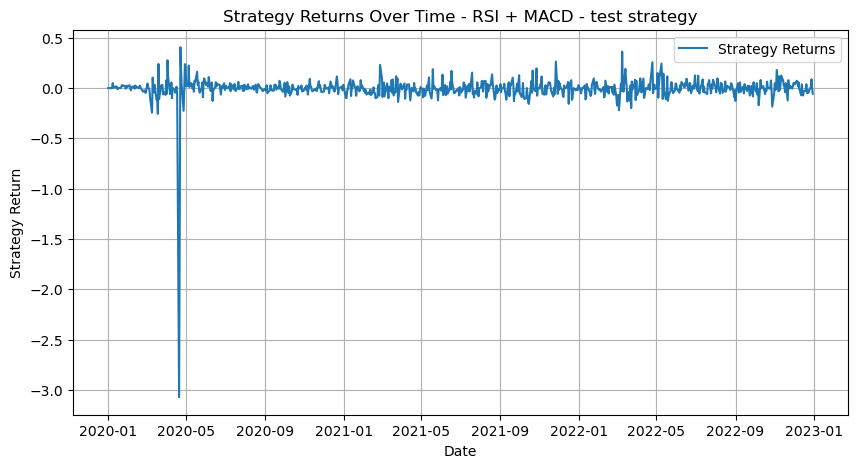

In [235]:
plot_strategy_returns(df_summed_returns_test, 'RSI + MACD - test')

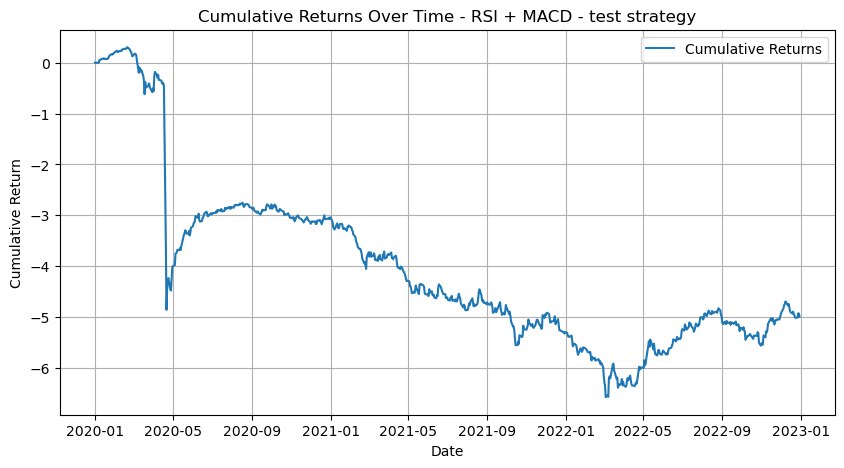

In [236]:
plot_cumulative_returns(df_cumulative_returns_test, 'RSI + MACD - test')

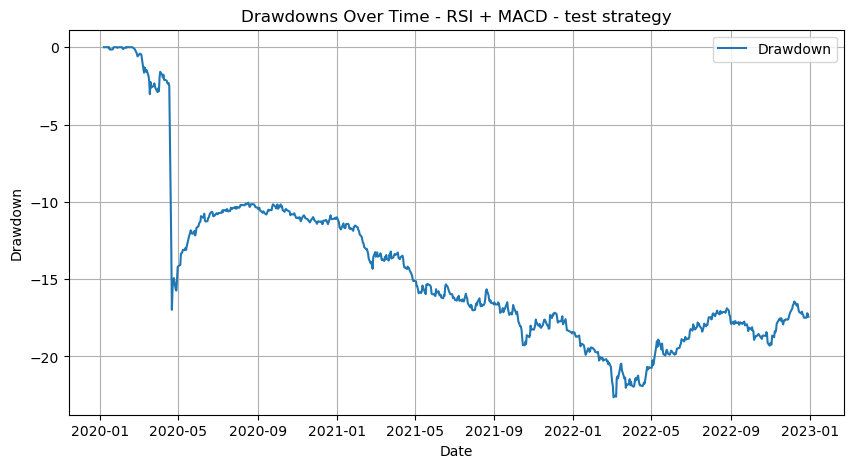

In [237]:
plot_drawdown(df_drawdown_test, 'RSI + MACD - test')

Combination strategy between RSI and MACD 0-line crossing strategy:

Buy when:

- RSI < 30 (oversold, ready to bounce)

- signal line crosses above 0 

Sell when:

- RSI > 70 (overbought)

- signal line crosses below 0 

In [238]:
def combined_rsi_macd_0line_strategy(df_rsi, df_macd, df_signal_line):
    """
    Combine RSI and MACD indicators to produce trading positions.
    Buy when RSI < 30 and MACD > Signal Line (bullish confirmation)
    Sell when RSI > 70 and MACD < Signal Line (bearish confirmation)
    Hold otherwise.

    Returns:
        df_positions: -1 = short, 1 = long
    """
    # Vectorized condition for buys (signal line > 0 and not NaN)
    buy = (df_rsi < 30) & (df_signal_line > 0) & df_signal_line.notna() 

    # Vectorized condition for sells (signal line < 0 and not NaN)
    sell = (df_rsi > 70) & (df_signal_line < 0) & df_signal_line.notna()

    # Convert to trade signal: +1 for buy, -1 for sell, 0 otherwise
    signals = buy.astype(int) - sell.astype(int)

    # Replace 0s with NaN to enable forward-filling
    signals = signals.replace(0, np.nan)

    # Forward fill to propagate current position
    df_positions = signals.ffill().fillna(0).astype(int)

    # Ensure only -1 or 1 (short or long)
    df_positions = df_positions.clip(-1, 1)

    return df_positions

In [239]:
def backtest_rsi_macd_0line_strategy(df_returns, df_rsi, df_macd, df_signal_line, df_vol):

    df_positions = combined_rsi_macd_0line_strategy(df_rsi, df_macd, df_signal_line)
    #df_weight_matrix = calculate_weight_matrix(df_positions, df_vol)
    df_weight_matrix = df_positions
    df_strategy_returns = calculate_strategy_returns(df_returns, df_weight_matrix)
    df_cumulative_returns, df_summed_returns = calculate_cumulative_returns(df_strategy_returns)
    sharpe_ratio = calculate_sharpe_ratio(df_summed_returns.to_numpy())

    return df_strategy_returns, df_cumulative_returns, df_summed_returns, df_weight_matrix, sharpe_ratio

In [240]:
df_strategy_returns_train, df_cumulative_returns_train, df_summed_returns_train, df_weight_matrix_train, sharpe_ratio_train = backtest_rsi_macd_0line_strategy(df_returns_train, df_rsi_train, df_macd_line_train, df_signal_line_train, df_vol_train)
df_strategy_returns_test, df_cumulative_returns_test, df_summed_returns_test, df_weight_matrix_test, sharpe_ratio_test = backtest_rsi_macd_0line_strategy(df_returns_test, df_rsi_test, df_macd_line_test, df_signal_line_test, df_vol_test)

In [241]:
df_drawdown_train = calculate_drawdown(df_cumulative_returns_train)
df_drawdown_test = calculate_drawdown(df_cumulative_returns_test)

In [242]:
sharpe_ratio_train

0.03918220327215048

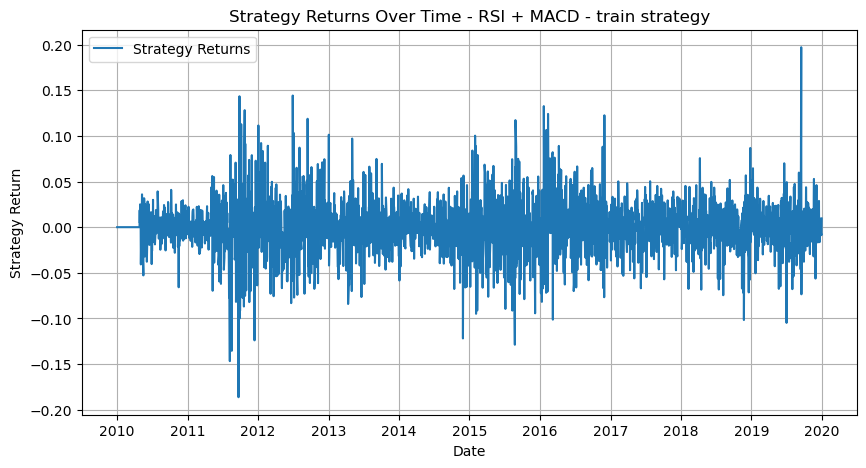

In [243]:
plot_strategy_returns(df_summed_returns_train, 'RSI + MACD - train')

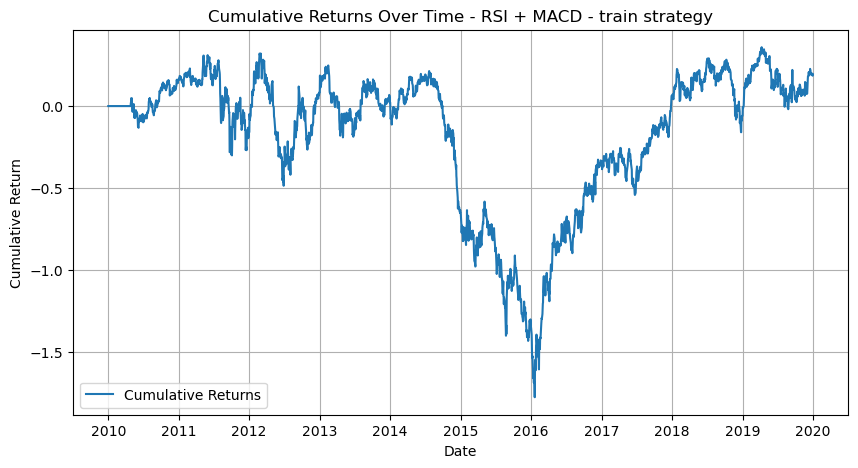

In [244]:
plot_cumulative_returns(df_cumulative_returns_train, 'RSI + MACD - train')

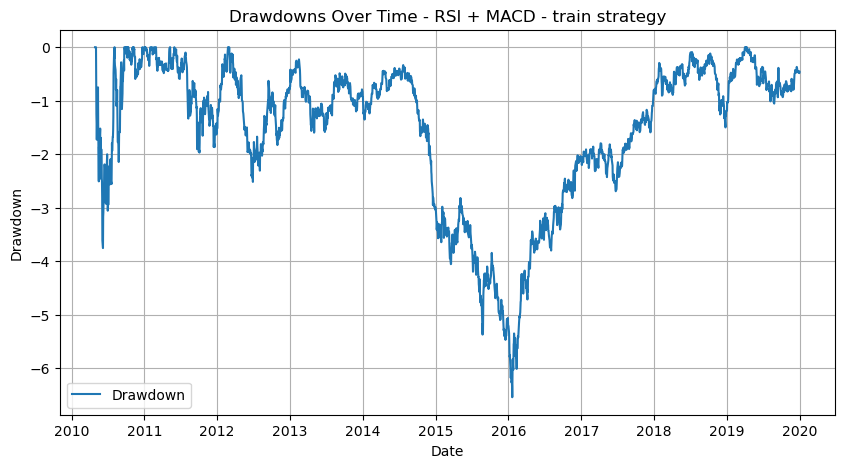

In [245]:
plot_drawdown(df_drawdown_train, 'RSI + MACD - train')

In [246]:
sharpe_ratio_test

0.6115667902340255

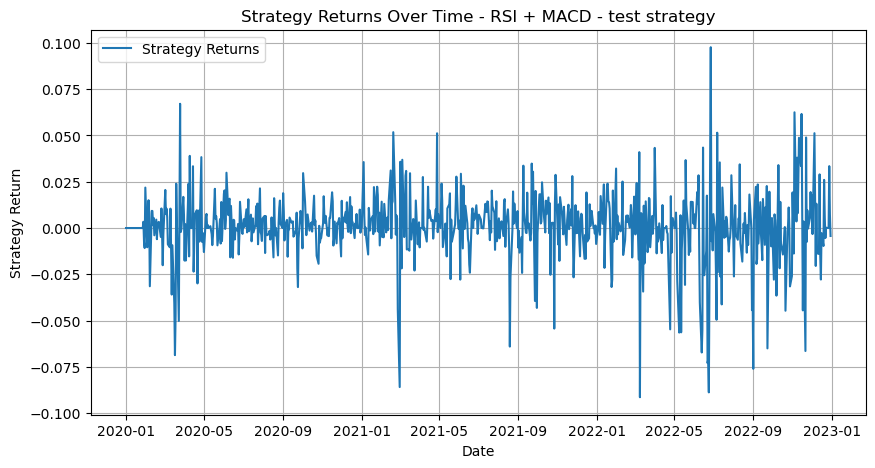

In [247]:
plot_strategy_returns(df_summed_returns_test, 'RSI + MACD - test')

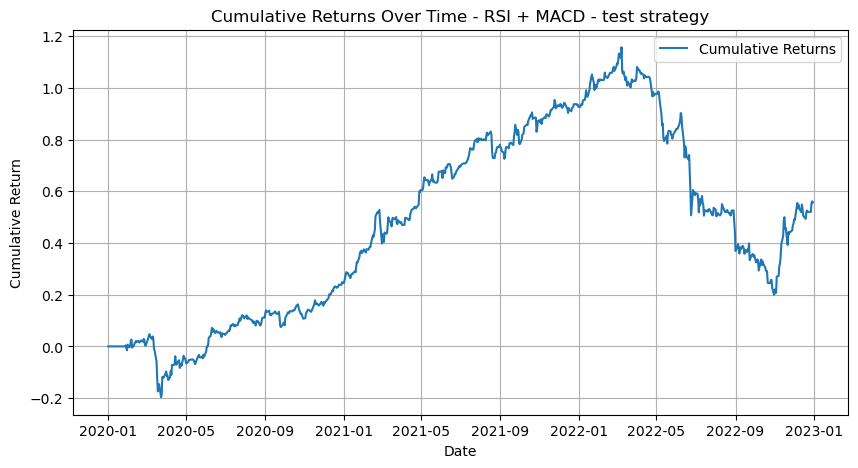

In [248]:
plot_cumulative_returns(df_cumulative_returns_test, 'RSI + MACD - test')

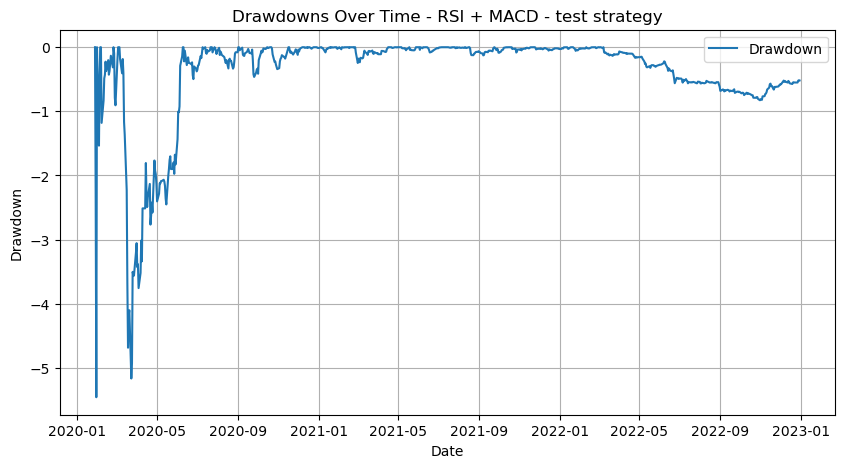

In [249]:
plot_drawdown(df_drawdown_test, 'RSI + MACD - test')